In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix,f1_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import itertools as it
import time as time
import xgboost as xgb

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Jackson Bremen & Lucy Han*

In [2]:
#data loading
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

data = pd.read_csv('../census-income.data',header=None)
data.columns=column_names

data['>50K'] = data['income'].apply(lambda x: 1 if '+' in x else 0)
target_count = data['>50K'].value_counts()

In [3]:
#visualizing response distribution
target_count = pd.DataFrame({'Income': target_count.index,'Count': target_count.values})
target_count = target_count.set_index('Income')
#Add normalized column
target_count['Percentage'] = 100*target_count['Count']/target_count['Count'].sum()
target_count

,Count,Percentage
Income,,
0,187141,93.794199
1,12382,6.205801


<AxesSubplot:title={'center':'Count (target)'}, xlabel='Income'>

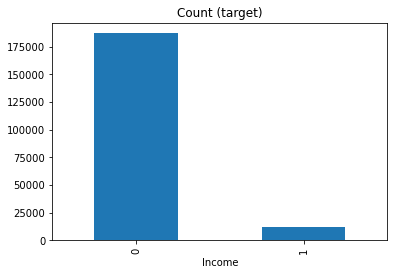

In [4]:
target_count['Count'].plot(kind='bar', title='Count (target)')

### Data cleaning
*By *

In [5]:
#...Code with comments...#

# Imputing missing values #

### Data preparation
*By name*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [6]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [7]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis
*By Lucy Han*

In [8]:
df = pd.read_csv('../data/census-income.data', header=None)
df.head(2)
data = pd.read_csv('../census-income.data',header=None)
data.columns=column_names
data['income'] = data['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [9]:
categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']
continuous_predictors = ['age', 'wage_hr','cap_gain', 'cap_loss', 'dividend','inst_weight', 
                         'num_ppl_worked', 'weeks_worked']

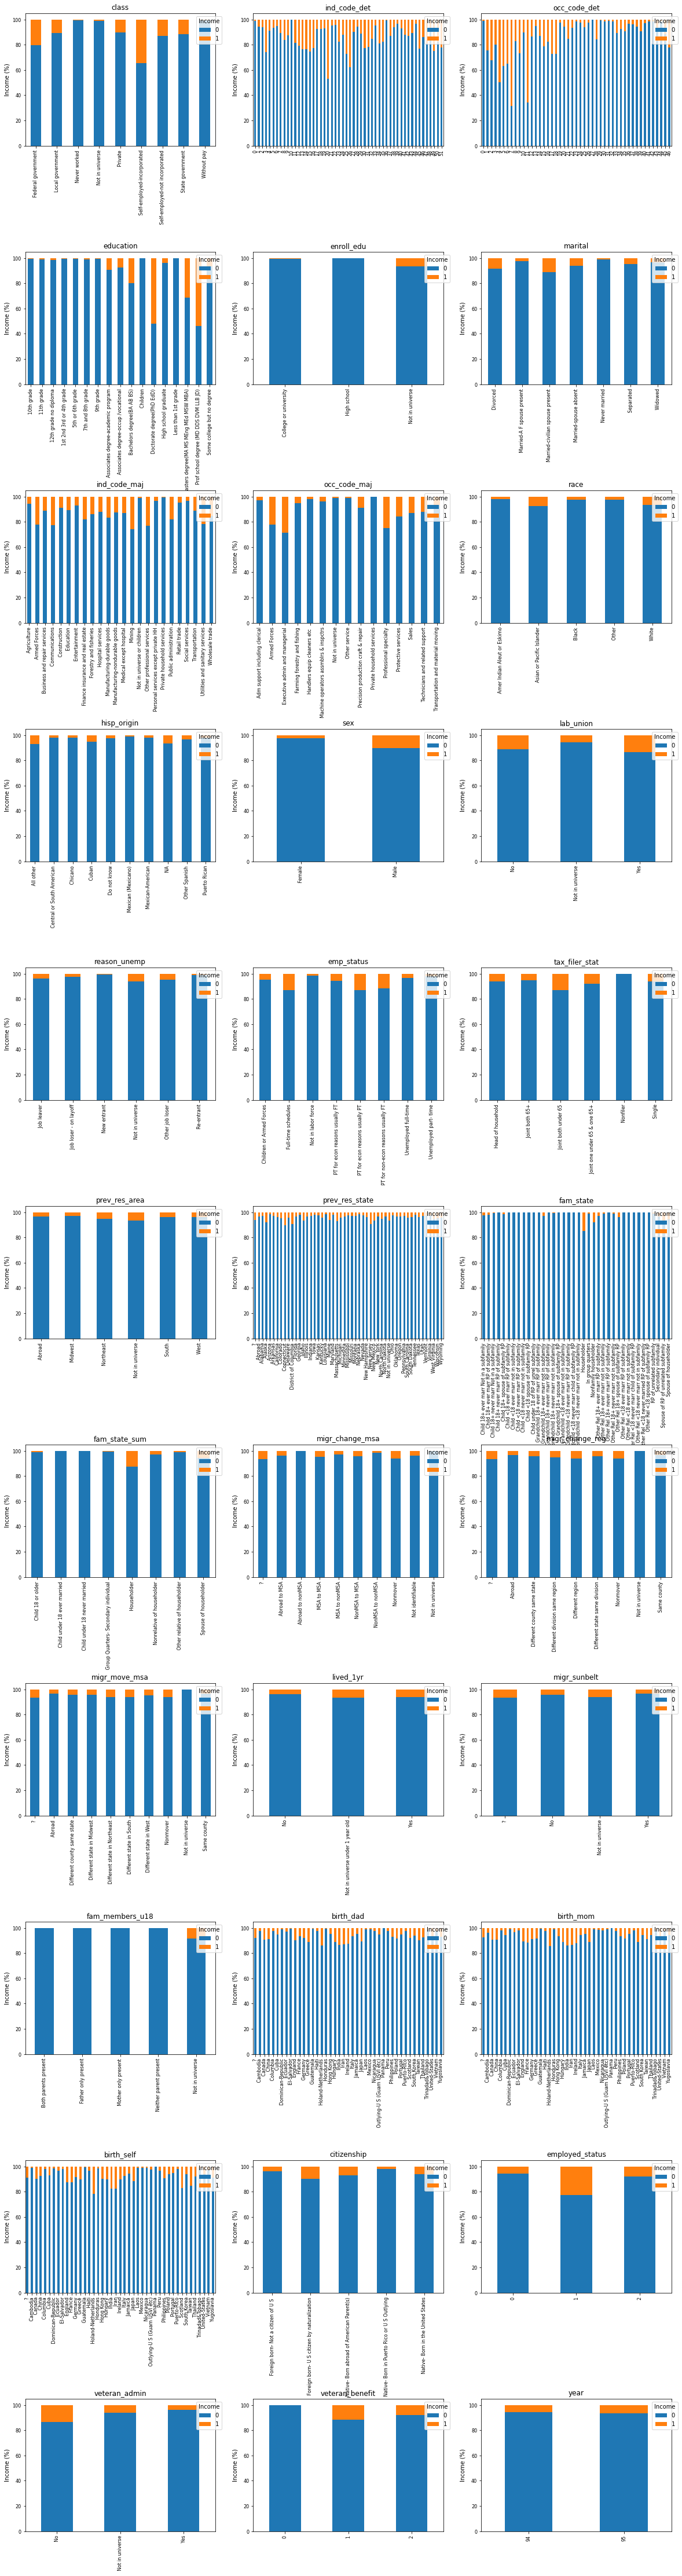

In [10]:
# Plotting categorical variables against response
n_rows = 11
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 80))

# Plotting stacked bar plots for categorical predictors
for i, predictor in enumerate(categorical_predictors):
    ax = axs[i // n_cols, i % n_cols]
    grouped_data = data.groupby([predictor, 'income'])['income'].count().unstack()
    totals = grouped_data.sum(axis=1)
    percent_data = grouped_data.div(totals, axis=0) * 100
    percent_data.plot.bar(stacked=True, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('Income (%)')
    ax.set_title(predictor)
    ax.legend(title='Income', loc='upper right', bbox_to_anchor=(1.05, 1))
    ax.tick_params(axis='both', labelsize=8)  

fig.subplots_adjust(hspace=0.8)
plt.show()

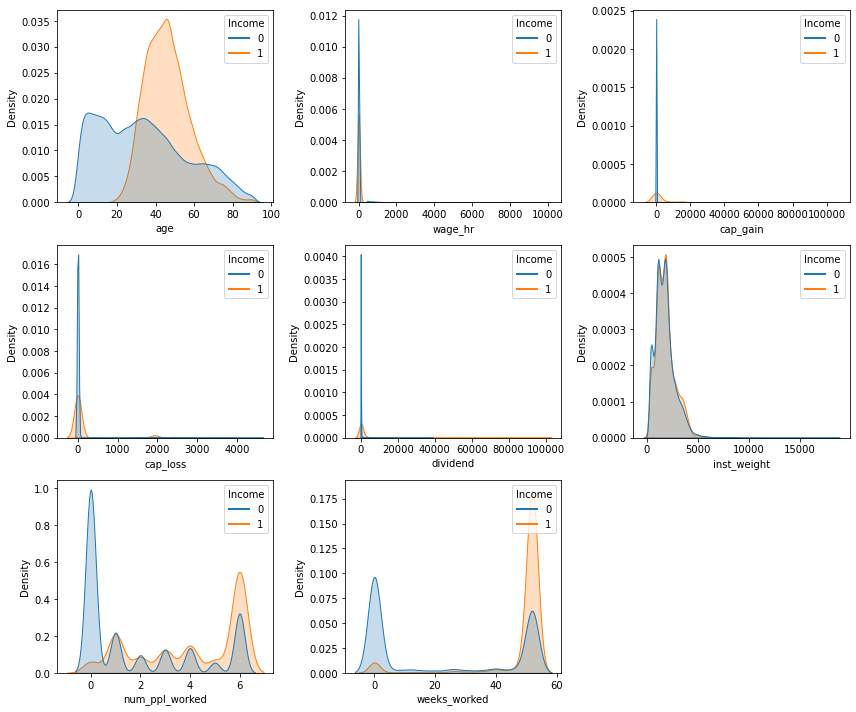

In [11]:
from matplotlib.lines import Line2D

n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10))

# Plotting density plots for continuous predictors against response.
for j, predictor in enumerate(continuous_predictors):
    ax = axs[j // n_cols, j % n_cols]
    sns.kdeplot(data=data, x=predictor, hue='income', ax=ax, fill=True, common_norm=False)
    ax.set_xlabel(predictor)
    ax.set_ylabel('Density')
    
    # Create custom legend entries
    legend_entries = []
    for income_value in data['income'].unique():
        legend_entry = Line2D([0],[0], color=sns.color_palette()[income_value], lw=2, label=income_value)
        legend_entries.append(legend_entry)
    ax.legend(handles=legend_entries, title='Income', loc='upper right')

# Removing any unused subplots
for i in range(len(continuous_predictors), n_rows * n_cols):
    if isinstance(axs, np.ndarray):
        fig.delaxes(axs.flatten()[i])
    else:
        fig.delaxes(axs[i // n_cols, i % n_cols])

fig.tight_layout()
plt.show()

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Lasso, Ridge & Catboost
*By Sylvia Sherwood*

### MARS, AdaBoost & LightGBM
*By Sankaranarayanan Balasubramanian*

### Bagged trees & Random forest
*By Fiona Fe*

### XGBoost
*By Lucy Han*

In [12]:
#data preparation for XGBoost
data_xgb = pd.read_csv('../data/census-income.data', header=None)
data_xgb = data_xgb.replace('?', np.nan)
data_xgb = data_xgb.replace(' ?', np.nan)
data_xgb.columns=column_names
#removed 4 columns with 50% missing value. Not realistic nor meaningful to impute these values.
data_xgb.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
data_xgb.dropna(inplace=True)
data_xgb.drop('inst_weight', axis=1, inplace=True)

In [13]:
train_xgb = data_xgb.copy()
train_xgb['income'] = train_xgb['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

test_xgb = pd.read_csv('../census-income.test',header=None)
test_xgb.columns=column_names
test_xgb.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
test_xgb.dropna(inplace=True)
test_xgb.drop('inst_weight', axis=1, inplace=True)
test_xgb['income'] = test_xgb['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [15]:
#label encoding. Have tried on-hot encoding, no difference in model performance. Thus used label to keep things cleaner
label = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'lived_1yr', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
for pred in label:
    train_xgb[pred] = lbl.fit_transform(train_xgb[pred])
    test_xgb[pred] = lbl.fit_transform(test_xgb[pred])
    train_xgb[pred] = train_xgb[pred]
train_xgb.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,73,3,0,0,12,0,2,6,14,6,...,39,39,39,4,0,1,2,0,1,0
1,58,6,4,34,16,0,2,0,4,8,...,39,39,39,4,0,1,2,52,0,0


In [27]:
def decision_threshold(model):
    threshold_hyperparam_vals = np.arange(0, 1.01, 0.01)

    predicted_class = cross_val_predict(model, X_train_xgb, y_train_xgb, cv=5)
    predicted_probability = model.predict_proba(X_train_xgb)

    results = []

    for threshold_prob in threshold_hyperparam_vals:
        predicted_class = (predicted_probability[:,1] > threshold_prob).astype(int)
        accuracy = accuracy_score(y_true=y_train_xgb,y_pred=predicted_class)
        recall = recall_score(y_true=y_train_xgb,y_pred=predicted_class)
        results.append({'Threshold': threshold_prob, 'Accuracy': accuracy, 'Recall': recall})
    df_results=pd.DataFrame(results)
    return df_results

def model_performance(model_opt,opt_threshold):
    train_predictions = (model_opt.predict_proba(X_train_xgb)[:, 1] > opt_threshold).astype(int)
    test_predictions = (model_opt.predict_proba(X_test_xgb)[:, 1] > opt_threshold).astype(int)

    train_accuracy = accuracy_score(y_true=y_train_xgb, y_pred=train_predictions)
    train_recall = recall_score(y_true=y_train_xgb, y_pred=train_predictions)
    train_precision = precision_score(y_true=y_train_xgb, y_pred=train_predictions)
    test_accuracy = accuracy_score(y_true=y_test_xgb, y_pred=test_predictions)
    test_recall = recall_score(y_true=y_test_xgb, y_pred=test_predictions)
    test_precision = precision_score(y_true=y_test_xgb, y_pred=test_predictions)
    
    print("Training accuracy:", train_accuracy)
    print("Training recall:", train_recall)
    print("Test accuracy:", test_accuracy)
    print("Test recall:", test_recall)

In [20]:
X_train_xgb = train_xgb.drop(['income'],axis = 1)
y_train_xgb = train_xgb.income
X_test_xgb = test_xgb.drop(['income'],axis = 1)
y_test_xgb = test_xgb.income
X_train_xgb.shape

(190561, 36)

In [23]:
#developing naive model for performance comparison
model_xgb_naive = xgb.XGBClassifier(objective='binary:logistic').fit(X_train_xgb,y_train_xgb)
df_naive_xgb = decision_threshold(model_xgb_naive)

In [25]:
filtered_df_xgb_naive = df_naive_xgb[(df_naive_xgb['Accuracy'] >= 0.9) & (df_naive_xgb['Recall'] >= 0.85)]
filtered_df_xgb_naive.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
8,0.08,0.901874,0.912242
9,0.09,0.909047,0.900232
10,0.10,0.915518,0.889508
11,0.11,0.921180,0.879043
12,0.12,0.925656,0.867805
13,0.13,0.930280,0.858712


In [28]:
model_performance(model_xgb_naive,0.08)

Training accuracy: 0.9018739406279355
Training recall: 0.9122415715878871
Test accuracy: 0.9187566408051162
Test recall: 0.7929194956353055


- Decent training results, but testing recall a bit low
- Without scaling imbalanced data and the threshold being 0.08, the naive model is classifying most observations as 0s. 
- This is the reason why we want higher recall, because we prioritize greater opportunities for individuals to achieve wealth, even if some factors may be uncertain or doubtful.

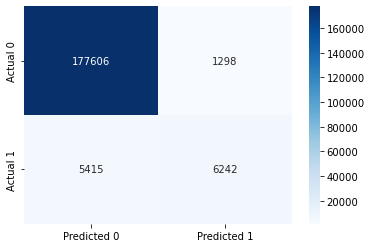

In [32]:
#training confusion matrix for naive xgb model
y_pred_naivetrain = model_xgb_naive.predict(X_train_xgb)
cm = pd.DataFrame(confusion_matrix(y_train_xgb, y_pred_naivetrain), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

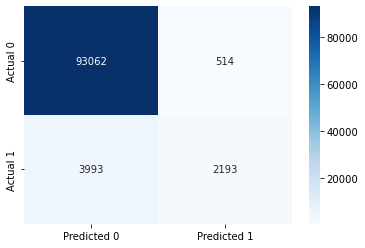

In [30]:
#testing confusion matrix for naive xgb model
y_pred_naive = model_xgb_naive.predict(X_test_xgb)
cm = pd.DataFrame(confusion_matrix(y_test_xgb, y_pred_naive), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [34]:
#calculating scale for hyperparameter: scale_pos_weight
#sum(negative instances) / sum(positive instances)
(y_train_xgb.shape[0]-y_train_xgb.sum())/y_train_xgb.sum()

15.347344942952732

In [36]:
#grid search for final XGB model.
#since random_state is not set, the optimal hyperparam result will be different for every pass.

start_time = time.time()
param_grid = {'max_depth': [8],
              'learning_rate': [0.01,0.1],
              'reg_lambda': [1,10],
              'n_estimators': [500,800,1000],
              'gamma': [1,10],
              'subsample': [0.5],
              'colsample_bytree':[0.5],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train_xgb, y_train_xgb)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 0.5, 'scale_pos_weight': 15, 'reg_lambda': 10, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.5}
Optimal cross validation score = 0.9289413865039315
Time taken = 10  minutes


In [39]:
#final xgb model. Might not have the same hyperparam with above grid, due to randomized search w/o setting random_state
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth = 8, 
                              learning_rate = 0.01,
                              n_estimators = 1000,
                              reg_lambda = 10, 
                              gamma = 10, 
                              subsample = 0.5, 
                              colsample_bytree=0.5, 
                              scale_pos_weight=15).fit(X_train_xgb,y_train_xgb)
decision_threshold_xgb = decision_threshold(model_xgb)

In [45]:
#tuning decision probability threshold
filtered_df_xgb = decision_threshold_xgb[(decision_threshold_xgb['Accuracy'] >= 0.85) & (decision_threshold_xgb['Recall'] >= 0.85)]
filtered_df_xgb.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
39,0.39,0.851402,0.953676
40,0.40,0.854708,0.952389
41,0.41,0.857505,0.950244
42,0.42,0.860575,0.947757
43,0.43,0.863870,0.945183
44,0.44,0.866914,0.943039
45,0.45,0.870068,0.939350
46,0.46,0.872891,0.936690
47,0.47,0.875882,0.933602
48,0.48,0.878921,0.929141


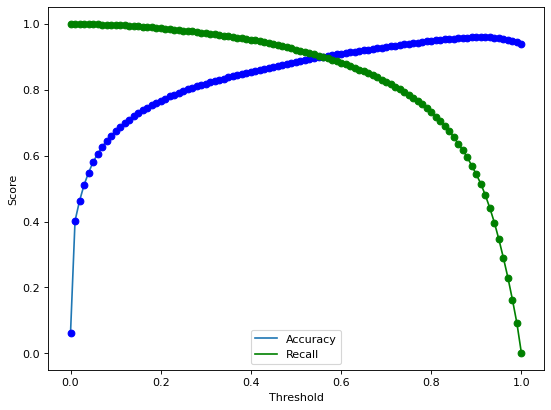

In [41]:
#visualizing different decision threshold combinations
plt.figure(figsize=(8,6),dpi=80)
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Accuracy'],label='Accuracy')
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Accuracy'],'o',color='blue')
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Recall'],label='Recall',color='green')
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Recall'],'o',color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [42]:
#displaying final model performance using selected optimal threshold
model_performance(model_xgb,0.53)

Training accuracy: 0.8926433005704211
Training recall: 0.9111263618426696
Test accuracy: 0.9065977025320262
Test recall: 0.8507921112188813


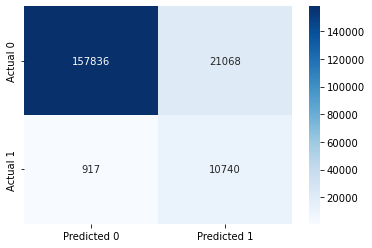

In [43]:
#training cm for final xgb model
y_pred_xgbtrain = model_xgb.predict(X_train_xgb)
cm = pd.DataFrame(confusion_matrix(y_train_xgb, y_pred_xgbtrain), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

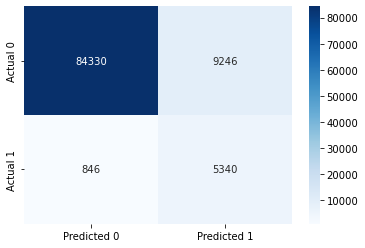

In [46]:
#testing cm for final xgb model
y_pred_xgb = model_xgb.predict(X_test_xgb)
cm = pd.DataFrame(confusion_matrix(y_test_xgb, y_pred_xgb), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [47]:
#feature importance for XGBoost model
importance = list(model_xgb.feature_importances_)
name = list(model_xgb.feature_names_in_)
df_imp_xgb = pd.DataFrame({'Feature Name':name,'Feature Importance':importance}).sort_values(by='Feature Importance', ascending=False)
df_imp_xgb.head(10)

,Feature Name,Feature Importance
34,weeks_worked,0.161493
12,sex,0.115426
25,num_ppl_worked,0.089569
26,fam_members_u18,0.085098
3,occ_code_det,0.048995
18,dividend,0.046808
16,cap_gain,0.045381
0,age,0.038161
22,fam_state,0.036734
23,fam_state_sum,0.029409


## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.